In [1]:
import matplotlib.pyplot as plt
# import sxs
import numpy as np
import astropy.units as u
from scipy.special import roots_legendre, sph_harm
from matplotlib.colors import LogNorm
from scipy.linalg import lstsq
import qnm
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12

# Load saved Data from SXS catalog

In [2]:
file = np.load("all_data_scri.npz",allow_pickle=True)
times = file['times']
spectra = file['spectra']
spectra_rot = file['spectra_rot']
#spectra_rot_p = file['spectra_rot_p']

remnant_masses = file['remnant_masses']
remnant_spin_amps = file['remnant_spin_amps']
theta_offsets = file['theta_offsets']
phi_offsets = file['phi_offsets']

mass_ratios = file['mass_ratios']
catalog_names = file['catalog_names']
mis_angs = file['mis_angs']
plunging_thetas = file['plunging_thetas']
plunging_phis = file['plunging_phis']
deltaJ_mis_angles = file['deltaJ_mis_angles']
Jdot_mis_angles = file['Jdot_mis_angles']

eccentricities = file['eccentricities']

In [3]:
eccentricities.shape

(1816,)

In [4]:
times.shape

(1816,)

In [5]:
eccentric_flag = (eccentricities<1e-3)

In [6]:
eccentric_flag.shape

(1816,)

In [7]:
times = times[eccentric_flag]
spectra = spectra[eccentric_flag]
spectra_rot = spectra_rot[eccentric_flag]
#spectra_rot_p = file['spectra_rot_p']

remnant_masses = remnant_masses[eccentric_flag]
remnant_spin_amps = remnant_spin_amps[eccentric_flag]
theta_offsets = theta_offsets[eccentric_flag]
phi_offsets = phi_offsets[eccentric_flag]

mass_ratios = mass_ratios[eccentric_flag]
catalog_names = catalog_names[eccentric_flag]
mis_angs = mis_angs[eccentric_flag]
plunging_thetas = plunging_thetas[eccentric_flag]
plunging_phis = plunging_phis[eccentric_flag]
deltaJ_mis_angles = deltaJ_mis_angles[eccentric_flag]
Jdot_mis_angles = Jdot_mis_angles[eccentric_flag]

In [8]:
def lm_index(l,m):
    return l**2+l+m-4

# Mode decomposition

Here, we fit over all l for given m simultaneously, taking into account of spherical-spheroidal mixing but not nonlinearity

Start by fitting two modes (fundamental and first overtone) for each l and m?

In [9]:
# prograde modes
def qnm_pro_lmn(t, spin, mass, l, m, n, lmax = 4):
    # calcuate frequency and mixing constants for mode
    mode_seq = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, A, C = mode_seq(a=spin)
    # rescale frequency by remnant mass
    omega/=mass
    return np.ravel(np.outer(C[:lmax+1-max(m,2)],np.exp(-1j*(omega*t))))
# retrograde modes
def qnm_retro_lmn(t, spin, mass, l, m, n, lmax = 4):
    # calcuate frequency and mixing constants for mode
    mode_seq = qnm.modes_cache(s=-2,l=l,m=-m,n=n)
    omega, A, C = mode_seq(a=spin)
    # rescale frequency by remnant mass
    omega/=mass
    omega = -np.conjugate(omega)
    return np.ravel(np.outer(C[:lmax+1-max(m,2)],np.exp(-1j*(omega*t))))

# design matrix for fitting
def fitting_matrix(t, t0, spec, spin, mass, m, lmax = 4, overtone = 2):
    """
    t : time, array-like
    spin : spin of remnant black hole
    mass : mass of remnant black hole
    m : azimuthal mode to fit
    overtone : number of overtones to include for each l \in [max(m,2),8]
    """
    
    # l modes to fit, ensureing l>=m
    ls = np.arange(max(m,2),lmax+1)
    
    # overtones to fit:
    overtones = np.arange(overtone)
    
    # prepare data (rhs)

    data = []
    for l in ls:
        data.append(spec[t>t0,lm_index(l,m)])
    data = np.ravel(np.array(data))
    t = t[t>t0]

    # initialize matrix
    M = np.zeros((t.shape[0]*len(ls),2*len(ls)*len(overtones)),dtype='complex128')
    # initialize index for l and n
    index = []
    ind = 0
    for l in ls:
        for n in overtones:
            M[:,2*ind] = qnm_pro_lmn(t,spin,mass,l,m,n, lmax)
            M[:,2*ind+1] = qnm_retro_lmn(t,spin,mass,l,m,n, lmax)
            ind+=1
            # mode index, retrograde are represented as -l
            index.append([l,n])
            index.append([-l,n])
    
    index = np.array(index)
    amps = lstsq(M,data)[0]
    sig = np.matmul(M,amps)
    res = data-sig
    # amps_err = lstsq(M,res)[0]
    sig = sig.reshape(len(ls),t.shape[0])
    #plt.imshow(np.abs(M),aspect='auto',interpolation='none',norm=LogNorm())
    res = res.reshape(len(ls),t.shape[0])
    return(t, amps, sig, res, index)

## Focusing on one case: SXS:BBH:2070

### m=2

In [10]:
runind = 2070
runname = "SXS:BBH:%04d"%runind
cond = catalog_names==runname

m = 2
lmax = 5
overtone = 4
spin = remnant_spin_amps[cond][0]
mass = remnant_masses[cond][0]
# normalize time to be 1 at the formation of common horizon
t = times[cond][0]-times[cond][0][0]
spec = spectra_rot[cond][0]

# Construct design matrix
# M, index = fitting_matrix(t, spin, mass, m, lmax = lmax)

#### Trial fit data

In [11]:
#find the time for peak amplitude
tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

In [12]:
t0=tmax
t1, amps, sig, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

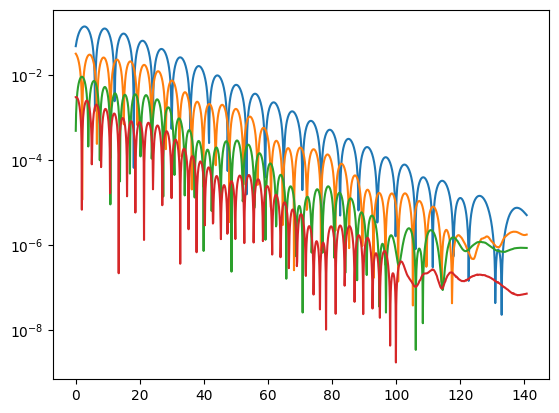

In [13]:
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(2,2)].real),label='22')
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(3,2)].real),label='32')
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(4,2)].real),label='42')
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(5,2)].real),label='52')

plt.yscale('log')

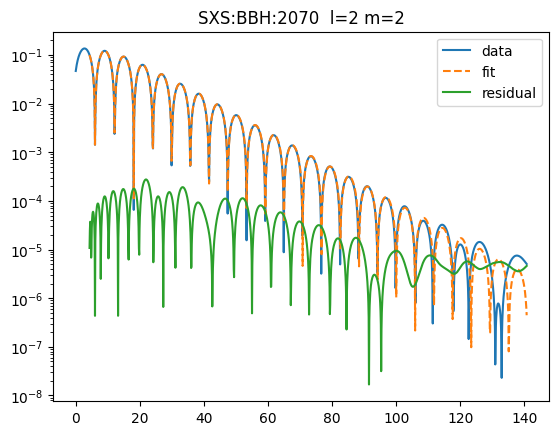

In [14]:
lplot,mplot = 2,2
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(t1,np.abs(sig[lplot-max(m,2)].real),'--',label='fit')
plt.plot(t1,np.abs(res[lplot-max(m,2)].real),label='residual')
plt.title("SXS:BBH:%04d  l=%s m=%s"%(runind,lplot,mplot))
plt.legend()

plt.yscale('log')

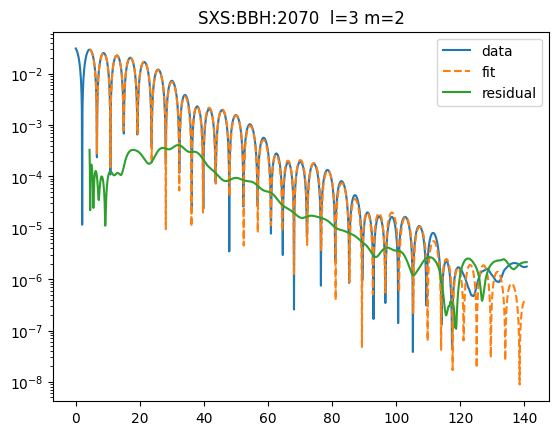

In [15]:
lplot,mplot = 3,2
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(t1,np.abs(sig[lplot-max(m,2)].real),'--',label='fit')
plt.plot(t1,np.abs(res[lplot-max(m,2)]),label='residual')
plt.title("SXS:BBH:%04d  l=%s m=%s"%(runind,lplot,mplot))

plt.legend()

plt.yscale('log')

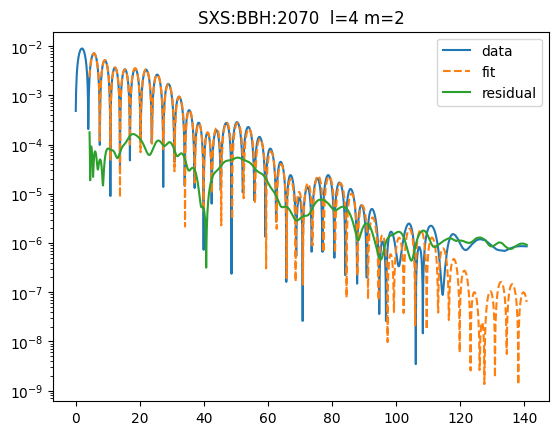

In [16]:
lplot,mplot = 4,2
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(t1,np.abs(sig[lplot-max(m,2)].real),'--',label='fit')
plt.plot(t1,np.abs(res[lplot-max(m,2)]),label='residual')
plt.title("SXS:BBH:%04d  l=%s m=%s"%(runind,lplot,mplot))
plt.legend()


plt.yscale('log')

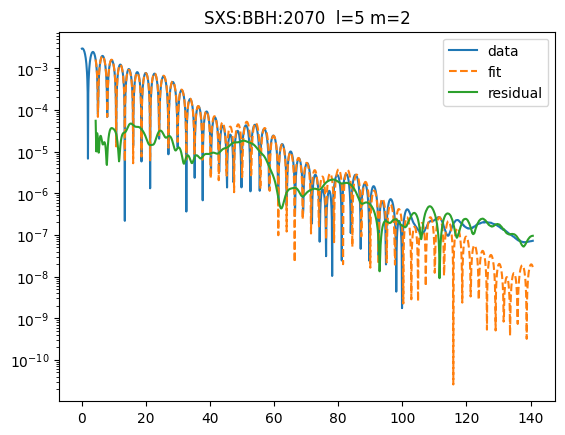

In [17]:
lplot,mplot = 5,2
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(t1,np.abs(sig[lplot-max(m,2)].real),'--',label='fit')
plt.plot(t1,np.abs(res[lplot-max(m,2)]),label='residual')
plt.title("SXS:BBH:%04d  l=%s m=%s"%(runind,lplot,mplot))

plt.legend()


plt.yscale('log')

In [18]:
runind = 2070
runname = "SXS:BBH:%04d"%runind
cond = catalog_names==runname

m = 1
lmax = 5
overtone = 4
spin = remnant_spin_amps[cond][0]
mass = remnant_masses[cond][0]
# normalize time to be 1 at the formation of common horizon
t = times[cond][0]-times[cond][0][0]
spec = spectra_rot[cond][0]

# Construct design matrix
# M, index = fitting_matrix(t, spin, mass, m, lmax = lmax)

#### Trial fit data

In [19]:
#find the time for peak amplitude
tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

In [20]:
t0=tmax
t1, amps, sig, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

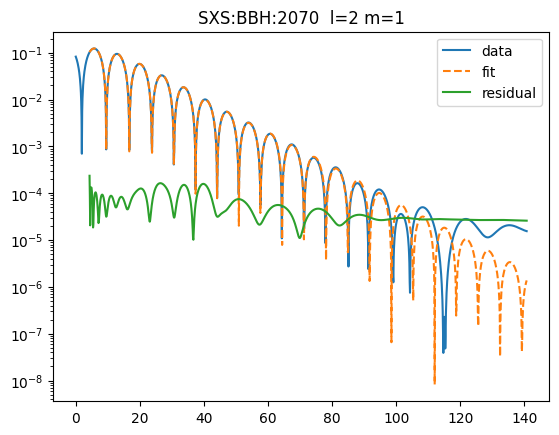

In [21]:
lplot,mplot = 2,1
plt.plot(t,np.abs(spectra_rot[cond][0][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(t1,np.abs(sig[lplot-max(m,2)].real),'--',label='fit')
plt.plot(t1,np.abs(res[lplot-max(m,2)]),label='residual')
plt.title("SXS:BBH:%04d  l=%s m=%s"%(runind,lplot,mplot))
plt.legend()

plt.yscale('log')

# Fit all data

## m=0

In [37]:
# holder for time over which the data is fitted
tfit0s = []

# amplitude for each modes
amp0s = []

# amplitude error
amp0s_err = []
# indices to identify amplitudes with modes
indice0s = []

# best fit values
fit0s = []

# fitting residual
res0s = []

# fitting flag 1 success, 0 failed
flag0s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = 0

        # which l modes to include
        lmax = 4

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfit0s.append(tfit)
        amp0s.append(np.mean(amps,axis=0))
        amp0s_err.append(np.std(amps,axis=0))

        indice0s.append(index)
        fit0s.append(fit)
        res0s.append(res)
        flag0s.append(1)
        print("%s done"%catalog_names[i])
    except:
        print("fitting for %s failed"%catalog_names[i])
        flag0s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfit0s.append(tfit)
        amp0s.append(np.mean(amps,axis=0))
        amp0s_err.append(np.std(amps,axis=0))
        indice0s.append(index)
        fit0s.append(fit)
        res0s.append(res)

SXS:BBH:0200 done
SXS:BBH:0201 done
SXS:BBH:0202 done
SXS:BBH:0203 done
SXS:BBH:0204 done
SXS:BBH:0205 done
SXS:BBH:0206 done
SXS:BBH:0207 done
SXS:BBH:0208 done
SXS:BBH:0209 done
SXS:BBH:0210 done
SXS:BBH:0211 done
SXS:BBH:0212 done
SXS:BBH:0213 done
SXS:BBH:0214 done
SXS:BBH:0215 done
SXS:BBH:0216 done
SXS:BBH:0217 done
SXS:BBH:0218 done
SXS:BBH:0219 done
SXS:BBH:0220 done
SXS:BBH:0221 done
SXS:BBH:0222 done
SXS:BBH:0224 done
SXS:BBH:0225 done
SXS:BBH:0226 done
SXS:BBH:0227 done
SXS:BBH:0228 done
SXS:BBH:0229 done
SXS:BBH:0230 done
SXS:BBH:0231 done
SXS:BBH:0232 done
SXS:BBH:0233 done
SXS:BBH:0234 done
SXS:BBH:0235 done
SXS:BBH:0236 done
SXS:BBH:0237 done
SXS:BBH:0238 done
SXS:BBH:0239 done
SXS:BBH:0240 done
SXS:BBH:0241 done
SXS:BBH:0242 done
SXS:BBH:0243 done
SXS:BBH:0244 done
SXS:BBH:0245 done
SXS:BBH:0247 done
SXS:BBH:0248 done
SXS:BBH:0249 done
SXS:BBH:0250 done
SXS:BBH:0251 done
SXS:BBH:0252 done
SXS:BBH:0253 done
SXS:BBH:0254 done
SXS:BBH:0255 done
SXS:BBH:0256 done
SXS:BBH:02

SXS:BBH:0684 done
SXS:BBH:0685 done
SXS:BBH:0686 done
SXS:BBH:0687 done
SXS:BBH:0688 done
SXS:BBH:0689 done
SXS:BBH:0690 done
SXS:BBH:0691 done
SXS:BBH:0692 done
SXS:BBH:0693 done
SXS:BBH:0694 done
SXS:BBH:0695 done
SXS:BBH:0696 done
SXS:BBH:0697 done
SXS:BBH:0698 done
SXS:BBH:0699 done
SXS:BBH:0700 done
SXS:BBH:0701 done
SXS:BBH:0702 done
SXS:BBH:0703 done
SXS:BBH:0704 done
SXS:BBH:0705 done
SXS:BBH:0706 done
SXS:BBH:0707 done
SXS:BBH:0708 done
SXS:BBH:0709 done
SXS:BBH:0710 done
SXS:BBH:0711 done
SXS:BBH:0712 done
SXS:BBH:0713 done
SXS:BBH:0714 done
SXS:BBH:0715 done
SXS:BBH:0716 done
SXS:BBH:0717 done
SXS:BBH:0718 done
SXS:BBH:0719 done
SXS:BBH:0720 done
SXS:BBH:0721 done
SXS:BBH:0722 done
SXS:BBH:0723 done
SXS:BBH:0724 done
SXS:BBH:0725 done
SXS:BBH:0726 done
SXS:BBH:0727 done
SXS:BBH:0728 done
SXS:BBH:0729 done
SXS:BBH:0730 done
SXS:BBH:0731 done
SXS:BBH:0732 done
SXS:BBH:0733 done
SXS:BBH:0734 done
SXS:BBH:0735 done
SXS:BBH:0736 done
SXS:BBH:0737 done
SXS:BBH:0738 done
SXS:BBH:07

SXS:BBH:1166 done
SXS:BBH:1167 done
SXS:BBH:1172 done
SXS:BBH:1173 done
SXS:BBH:1174 done
SXS:BBH:1175 done
SXS:BBH:1178 done
SXS:BBH:1179 done
SXS:BBH:1184 done
SXS:BBH:1185 done
SXS:BBH:1186 done
SXS:BBH:1187 done
SXS:BBH:1188 done
SXS:BBH:1189 done
SXS:BBH:1190 done
SXS:BBH:1191 done
SXS:BBH:1192 done
SXS:BBH:1193 done
SXS:BBH:1194 done
SXS:BBH:1195 done
SXS:BBH:1196 done
SXS:BBH:1197 done
SXS:BBH:1198 done
SXS:BBH:1199 done
SXS:BBH:1200 done
SXS:BBH:1201 done
SXS:BBH:1202 done
SXS:BBH:1203 done
SXS:BBH:1204 done
SXS:BBH:1205 done
SXS:BBH:1206 done
SXS:BBH:1207 done
SXS:BBH:1208 done
SXS:BBH:1209 done
SXS:BBH:1210 done
SXS:BBH:1211 done
SXS:BBH:1212 done
SXS:BBH:1213 done
SXS:BBH:1214 done
SXS:BBH:1215 done
SXS:BBH:1216 done
SXS:BBH:1217 done
SXS:BBH:1218 done
SXS:BBH:1219 done
SXS:BBH:1220 done
SXS:BBH:1221 done
SXS:BBH:1222 done
SXS:BBH:1223 done
SXS:BBH:1224 done
SXS:BBH:1346 done
SXS:BBH:1347 done
SXS:BBH:1348 done
SXS:BBH:1349 done
SXS:BBH:1350 done
SXS:BBH:1351 done
SXS:BBH:13

SXS:BBH:1792 done
SXS:BBH:1793 done
SXS:BBH:1794 done
SXS:BBH:1795 done
SXS:BBH:1796 done
SXS:BBH:1797 done
SXS:BBH:1798 done
SXS:BBH:1799 done
SXS:BBH:1800 done
SXS:BBH:1801 done
SXS:BBH:1802 done
SXS:BBH:1803 done
SXS:BBH:1804 done
SXS:BBH:1805 done
SXS:BBH:1806 done
SXS:BBH:1807 done
SXS:BBH:1808 done
SXS:BBH:1809 done
SXS:BBH:1810 done
SXS:BBH:1811 done
SXS:BBH:1812 done
SXS:BBH:1813 done
SXS:BBH:1814 done
SXS:BBH:1815 done
SXS:BBH:1816 done
SXS:BBH:1817 done
SXS:BBH:1818 done
SXS:BBH:1819 done
SXS:BBH:1820 done
SXS:BBH:1821 done
SXS:BBH:1822 done
SXS:BBH:1823 done
SXS:BBH:1824 done
SXS:BBH:1825 done
SXS:BBH:1826 done
SXS:BBH:1827 done
SXS:BBH:1828 done
SXS:BBH:1829 done
SXS:BBH:1830 done
SXS:BBH:1831 done
SXS:BBH:1832 done
SXS:BBH:1833 done
SXS:BBH:1834 done
SXS:BBH:1835 done
SXS:BBH:1836 done
SXS:BBH:1837 done
SXS:BBH:1838 done
SXS:BBH:1839 done
SXS:BBH:1840 done
SXS:BBH:1841 done
SXS:BBH:1842 done
SXS:BBH:1843 done
SXS:BBH:1844 done
SXS:BBH:1845 done
SXS:BBH:1846 done
SXS:BBH:18

## m=1

In [24]:
# holder for time over which the data is fitted
tfit1s = []

# amplitude for each modes
amp1s = []

amp1s_err = []

# indices to identify amplitudes with modes
indice1s = []

# best fit values
fit1s = []

# fitting residual
res1s = []

# fitting flag 1 success, 0 failed
flag1s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = 1

        # which l modes to include
        lmax = 5

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfit1s.append(tfit)
        amp1s.append(np.mean(amps,axis=0))
        amp1s_err.append(np.std(amps,axis=0))

        # set fitting start time to be the peak amplitude
        #t0=tmax

        # perform fitting, output amplitude, mode indices, best fit, residual, etc.
        #tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

        #tfit1s.append(tfit)
        #amp1s.append(amp)
        indice1s.append(index)
        fit1s.append(fit)
        res1s.append(res)
        flag1s.append(1)
    except:
        print("fitting for %s failed"%catalog_names[i])
        flag1s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfit1s.append(tfit)
        amp1s.append(np.mean(amps,axis=0))
        amp1s_err.append(np.std(amps,axis=0))
        indice1s.append(index)
        fit1s.append(fit)
        res1s.append(res)

## m=2

Here, we fit all data with qnms given horizon mass and spin, taking into account of spherical-spheroidal mixing. 

In [25]:
# holder for time over which the data is fitted
tfit2s = []

# amplitude for each modes
amp2s = []

amp2s_err = []


# indices to identify amplitudes with modes
indice2s = []

# best fit values
fit2s = []

# fitting residual
res2s = []

# fitting flag 1 success, 0 failed
flag2s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = 2

        # which l modes to include
        lmax = 5

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfit2s.append(tfit)
        amp2s.append(np.mean(amps,axis=0))
        amp2s_err.append(np.std(amps,axis=0))

        # perform fitting, output amplitude, mode indices, best fit, residual, etc.
        #tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

        #tfit2s.append(tfit)
        #amp2s.append(amp)
        indice2s.append(index)
        fit2s.append(fit)
        res2s.append(res)
        flag2s.append(1)
    except:
        print("fitting for %s failed"%catalog_names[i])
        flag2s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfit2s.append(tfit)
        amp2s.append(np.mean(amps,axis=0))
        amp2s_err.append(np.std(amps,axis=0))
        indice2s.append(index)
        fit2s.append(fit)
        res2s.append(res)

## m=3

In [26]:
# holder for time over which the data is fitted
tfit3s = []

# amplitude for each modes
amp3s = []

amp3s_err = []

# indices to identify amplitudes with modes
indice3s = []

# best fit values
fit3s = []

# fitting residual
res3s = []

# fitting flag 1 success, 0 failed
flag3s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = 3

        # which l modes to include
        lmax = 5

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        
        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfit3s.append(tfit)
        amp3s.append(np.mean(amps,axis=0))
        amp3s_err.append(np.std(amps,axis=0))
        
        # set fitting start time to be the peak amplitude
        #t0=tmax

        # perform fitting, output amplitude, mode indices, best fit, residual, etc.
        #tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

        #tfit3s.append(tfit)
        #amp3s.append(amp)
        indice3s.append(index)
        fit3s.append(fit)
        res3s.append(res)
        flag3s.append(1)
    except:
        print("fitting for %s failed"%catalog_names[i])
        flag3s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfit3s.append(tfit)
        amp3s.append(np.mean(amps,axis=0))
        amp3s_err.append(np.std(amps,axis=0))
        indice3s.append(index)
        fit3s.append(fit)
        res3s.append(res)

## m=4

In [27]:
# holder for time over which the data is fitted
tfit4s = []

# amplitude for each modes
amp4s = []

amp4s_err = []

# indices to identify amplitudes with modes
indice4s = []

# best fit values
fit4s = []

# fitting residual
res4s = []

# fitting flag 1 success, 0 failed
flag4s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = 4

        # which l modes to include
        lmax = 5

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        
        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfit4s.append(tfit)
        amp4s.append(np.mean(amps,axis=0))
        amp4s_err.append(np.std(amps,axis=0))
        
        # set fitting start time to be the peak amplitude
        #t0=tmax

        # perform fitting, output amplitude, mode indices, best fit, residual, etc.
        #tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

        #tfit3s.append(tfit)
        #amp3s.append(amp)
        indice4s.append(index)
        fit4s.append(fit)
        res4s.append(res)
        flag4s.append(1)
    except:
        print("fitting for %s failed"%catalog_names[i])
        flag4s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfit4s.append(tfit)
        amp4s.append(np.mean(amps,axis=0))
        amp4s_err.append(np.std(amps,axis=0))
        indice4s.append(index)
        fit4s.append(fit)
        res4s.append(res)

## m=-2

In [28]:
# holder for time over which the data is fitted
tfitm2s = []

# amplitude for each modes
ampm2s = []

ampm2s_err = []


# indices to identify amplitudes with modes
indicem2s = []

# best fit values
fitm2s = []

# fitting residual
resm2s = []

# fitting flag 1 success, 0 failed
flagm2s = []


# iterates over all runs on SXS catalog
for i in range(catalog_names.shape[0]):
    try:
        # m to fit
        m = -2

        # which l modes to include
        lmax = 5

        # numbers of overtone to include
        overtone = 4

        # remnant mass and spin
        spin = remnant_spin_amps[i]
        mass = remnant_masses[i]

        # load time and waveform 
        t = times[i]
        spec = spectra_rot[i]

        #find the time for peak amplitude
        tmax = t[np.sum(spec**2,axis=-1)==np.sum(spec**2,axis=-1).max()]

        # normalize time to be 1 at peak psi_4 amplitude
        t -= tmax

        # set fitting start time to be the peak amplitude
        t0s = np.linspace(tmax,tmax+10,5)
        
        tfits = []
        amps = []
        for t0 in t0s:
            # perform fitting, output amplitude, mode indices, best fit, residual, etc.
            tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)
            tfits.append(tfit)
            amps.append(amp)
        amps = np.abs(np.array(amps))

        tfitm2s.append(tfit)
        ampm2s.append(np.mean(amps,axis=0))
        ampm2s_err.append(np.std(amps,axis=0))
        # set fitting start time to be the peak amplitude
        #t0=tmax

        # perform fitting, output amplitude, mode indices, best fit, residual, etc.
        #tfit, amp, fit, res, index = fitting_matrix(t, t0, spec, spin, mass, m, lmax = lmax, overtone=overtone)

        #tfitm2s.append(tfit)
        #ampm2s.append(amp)
        indicem2s.append(index)
        fitm2s.append(fit)
        resm2s.append(res)
        flagm2s.append(1)
    except:
        print("fitting for %s failed"%catalog_names[i])
        flagm2s.append(0)
        
        # these values are junk, but just include them anyway and filter out by the flag latter in the analysis
        tfitm2s.append(tfit)
        ampm2s.append(np.mean(amps,axis=0))
        ampm2s_err.append(np.std(amps,axis=0))        
        indicem2s.append(index)
        fitm2s.append(fit)
        resm2s.append(res)

In [29]:
amp0s = np.array(amp0s)
amp0s_err = np.array(amp0s_err)

flag0s = np.array(flag0s)

amp1s = np.array(amp1s)
amp1s_err = np.array(amp1s_err)
flag1s = np.array(flag1s)

amp2s = np.array(amp2s)
amp2s_err = np.array(amp2s_err)
flag2s = np.array(flag2s)

amp3s = np.array(amp3s)
amp3s_err = np.array(amp3s_err)
flag3s = np.array(flag3s)

amp4s = np.array(amp4s)
amp4s_err = np.array(amp4s_err)
flag4s = np.array(flag4s)

ampm2s = np.array(ampm2s)
ampm2s_err = np.array(ampm2s_err)
flagm2s = np.array(flagm2s)

In [30]:
indice0s[0]

array([[ 2,  0],
       [-2,  0],
       [ 2,  1],
       [-2,  1],
       [ 2,  2],
       [-2,  2],
       [ 2,  3],
       [-2,  3],
       [ 3,  0],
       [-3,  0],
       [ 3,  1],
       [-3,  1],
       [ 3,  2],
       [-3,  2],
       [ 3,  3],
       [-3,  3],
       [ 4,  0],
       [-4,  0],
       [ 4,  1],
       [-4,  1],
       [ 4,  2],
       [-4,  2],
       [ 4,  3],
       [-4,  3]])

In [31]:
np.savez('qnm_decomposed.npz',remnant_spin_amps=remnant_spin_amps,mass_ratios=mass_ratios,catalog_names=catalog_names,
        mis_angs=mis_angs,deltaJ_mis_angles=deltaJ_mis_angles,Jdot_mis_angles=Jdot_mis_angles,amp0s=amp0s,amp0s_err=amp0s_err,
        amp1s=amp1s,amp1s_err=amp1s_err,amp2s=amp2s,amp2s_err=amp2s_err,amp3s=amp3s,amp3s_err=amp3s_err,ampm2s=ampm2s,
        ampm2s_err=ampm2s_err,amp4s=amp4s,amp4s_err=amp4s_err,theta_offsets=theta_offsets,index0=indice0s[0],
        index1=indice1s[0],index2=indice2s[0],index3=indice3s[0],index4=indice4s[0])

# Check fitting results

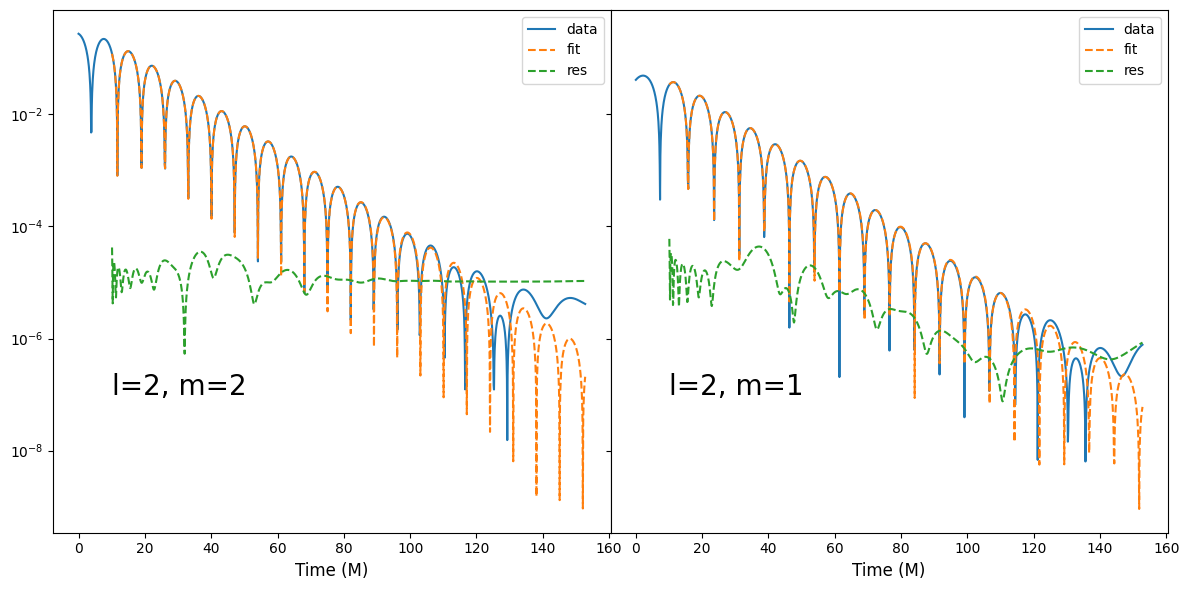

In [32]:
fig, row1 = plt.subplots(nrows=1,ncols=2, figsize = (12,6),sharex=True,sharey=True,gridspec_kw={'width_ratios':[1,1]})

#for i in range(2):
indplot = 1725
lplot,mplot = 2,2
#pcm = row1[i].plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
pcm = row1[0].plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
row1[0].plot(tfit2s[indplot],np.abs(fit2s[indplot][lplot-2].real),'--',label='fit')
row1[0].plot(tfit2s[indplot],np.abs(res2s[indplot][lplot-2]),'--',label='res')
#row1[i].plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
row1[0].legend()
row1[0].set_yscale('log')
row1[0].text(10,1e-7, 'l=2, m=2',fontsize=20)
lplot,mplot = 2,1
pcm = row1[1].plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
row1[1].plot(tfit1s[indplot],np.abs(fit1s[indplot][lplot-2].real),'--',label='fit')
row1[1].plot(tfit1s[indplot],np.abs(res1s[indplot][lplot-2]),'--',label='res')
#row1[i].plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
row1[1].legend()
row1[1].set_yscale('log')
#row1[i].set_ylim(1e-13,1e2)
#row1[i].set_xlim(-10,100)
row1[1].text(10,1e-7, 'l=2, m=1',fontsize=20)

#row1[0].set_ylabel("Orbital Frame")

row1[0].set_xlabel("Time (M)")
row1[1].set_xlabel("Time (M)")

fig.tight_layout()

plt.subplots_adjust(wspace=0,hspace=0)
#plt.savefig("./plots/fit_%s.png"%runind,dpi=200, bbox_inches='tight')

## m=0

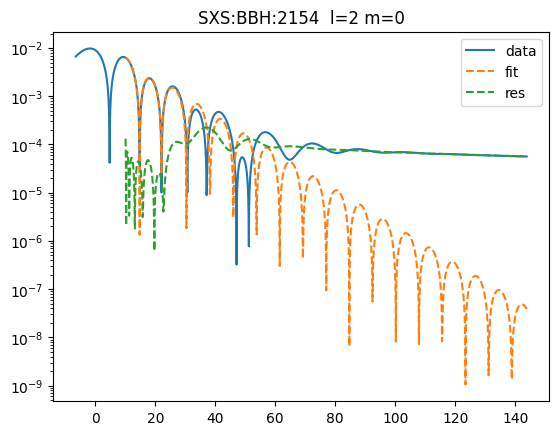

In [38]:
indplot = 1734
lplot,mplot = 2,0
plt.plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(tfit0s[indplot],np.abs(fit0s[indplot][lplot-2].real),'--',label='fit')
plt.plot(tfit0s[indplot],np.abs(res0s[indplot][lplot-2]),'--',label='res')
plt.title("%s  l=%s m=%s"%(catalog_names[indplot],lplot,mplot))
plt.legend()

plt.yscale('log')

## m=1

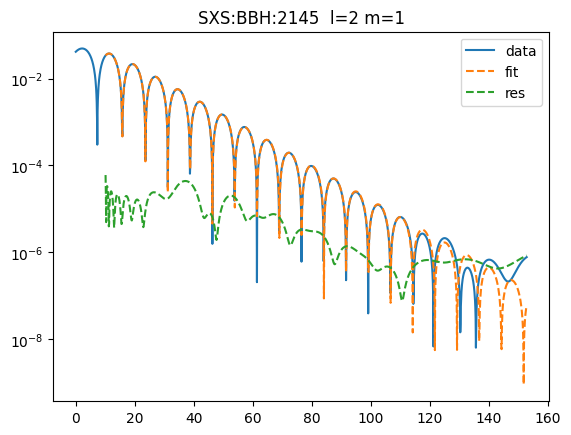

In [34]:
indplot = 1725
lplot,mplot = 2,1
plt.plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(tfit1s[indplot],np.abs(fit1s[indplot][lplot-2].real),'--',label='fit')
plt.plot(tfit1s[indplot],np.abs(res1s[indplot][lplot-2]),'--',label='res')
plt.title("%s  l=%s m=%s"%(catalog_names[indplot],lplot,mplot))
plt.legend()

plt.yscale('log')

## m=2

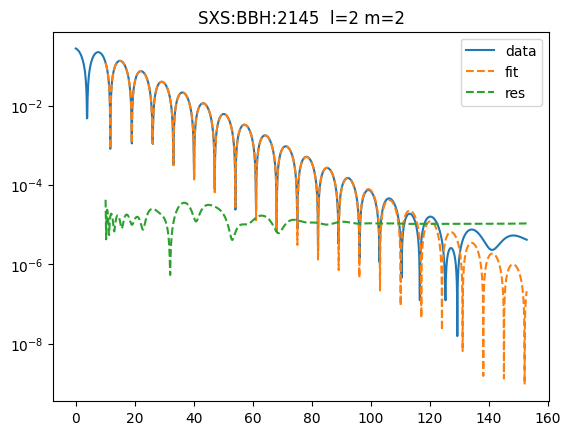

In [35]:
indplot = 1725
lplot,mplot = 2,2
plt.plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(tfit2s[indplot],np.abs(fit2s[indplot][lplot-2].real),'--',label='fit')
plt.plot(tfit2s[indplot],np.abs(res2s[indplot][lplot-2]),'--',label='res')
plt.title("%s  l=%s m=%s"%(catalog_names[indplot],lplot,mplot))
plt.legend()

plt.yscale('log')

## m=3

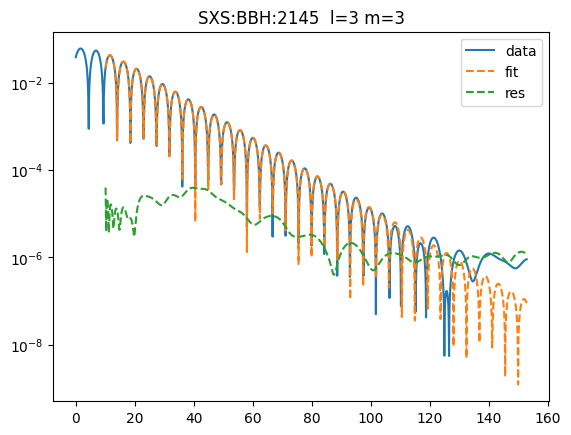

In [36]:
indplot = 1725
lplot,mplot = 3,3
plt.plot(times[indplot],np.abs(spectra_rot[indplot][:,lm_index(lplot,mplot)].real),label='data')
plt.plot(tfit3s[indplot],np.abs(fit3s[indplot][lplot-3].real),'--',label='fit')
plt.plot(tfit3s[indplot],np.abs(res3s[indplot][lplot-3]),'--',label='res')
plt.title("%s  l=%s m=%s"%(catalog_names[indplot],lplot,mplot))
plt.legend()

plt.yscale('log')